In [1]:
import numpy as np
#import os

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits

from setup import *

##--------------------------------------------------------------------------##
##             NECESSARY USER INPUTS BELOW....                              ##
##--------------------------------------------------------------------------##

##################
###   WASP4b   ###
##################
#obs_date='ut20150819'                           #observation date
#obj_name='Wasp4'                                #object name   
#midtime=['2015-08-19T07:43:00.00']                 #time of midtransit, WAsp-4b

###################
###   WASP52b   ###
###################
#obs_date='ut20160811'
obs_date='ut20160922'
obj_name='Wasp52'

#midtime=['2016-08-11T04:51:00']               #time of midtransit, Wasp-52b, Transit1
midtime=['2016-09-22T04:44:00']               #time of midtransit, Wasp-52b, Transit2

##################
###   Hats8b   ###
##################
#obs_date='ut20170723'                           #observation date
#obs_date='ut20170828'
#obj_name='Hats8'                                #object name  

#midtime=['2017-07-24T05:28:01.056']                 #time of midtransit, Hats-8b, Transit 1
#midtime=['2017-08-29T01:36:04.608']                 #time of midtransit, Hats-8b Transit 2


path='/Volumes/ermay_ext/Magellan/'+obs_date+'/'
data_path=path+obj_name+'_Spec/'      #path to where your data is saved
flat_path=path+obj_name+'_Flats/'     #path to where your SLIT flats are saved
DARKS=path+obj_name+'_Darks/'     #path to where your darks are saved
FLATS=path+'Full_Flats/'             #path to where the full field flats are saved 
WAVE=path+obj_name+'_Arcs/'

#SAVEPATH='SaveData/'+obj_name+'/'
SAVEPATH=path+'SaveData_'+obj_name+'/'

wavelength_path=path+'WaveSolution/'



extray=400 #number of extra pixels to extract per side in y direction
extrax=80  #number on the side to find wavelength strip, only for nights with a single mask


binn=1    #binning
#### CHECK BINNING IN SETUP.PY ####
#### if 1x1 binning, xpixels,ypixels should be 2048,4096
#### if 2x2 binning, xpixels,ypixels should be 1024,2048
print xpixels/binn, ypixels/binn

2048 4096


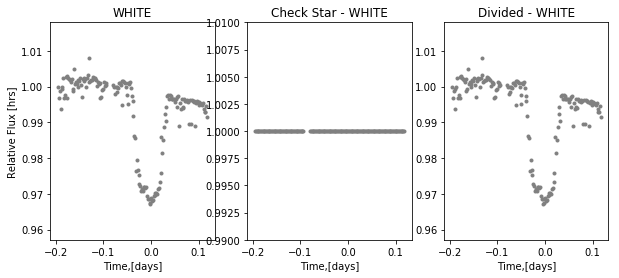

[ 4400.  4500.  4600.  4700.  4800.  4900.  5000.  5100.  5200.  5300.
  5400.  5500.  5600.  5700.  5800.  5900.  6000.  6100.  6200.  6300.
  6400.  6500.  6600.  6700.  6800.  6900.  7000.  7100.  7200.  7300.
  7400.  7500.  7600.  7700.  7800.  7900.  8000.]


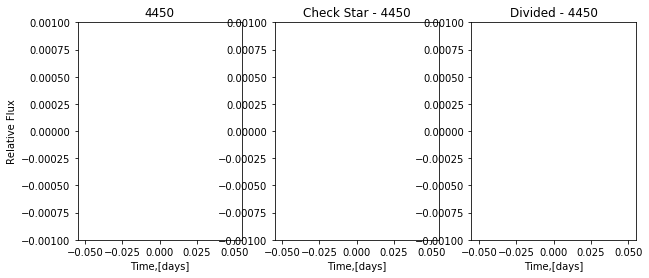

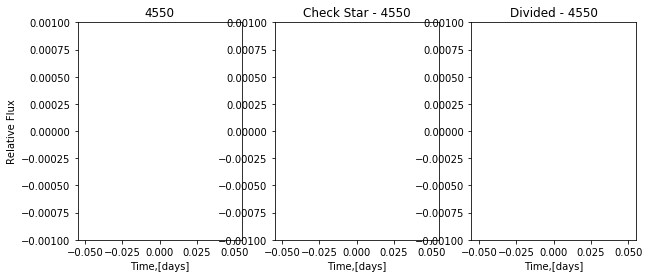

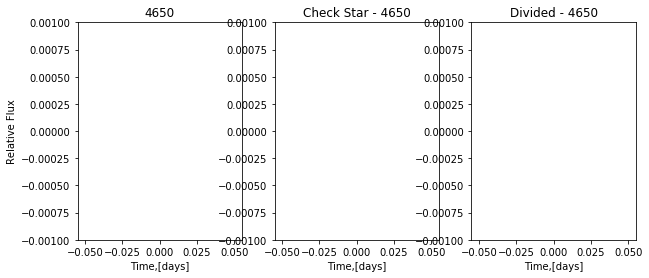

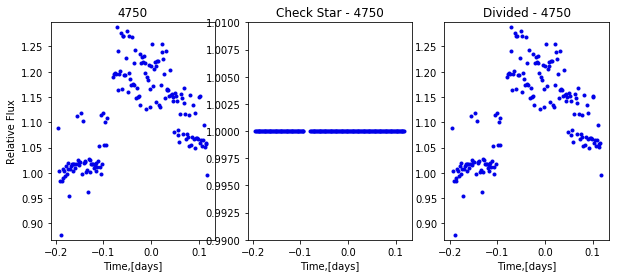

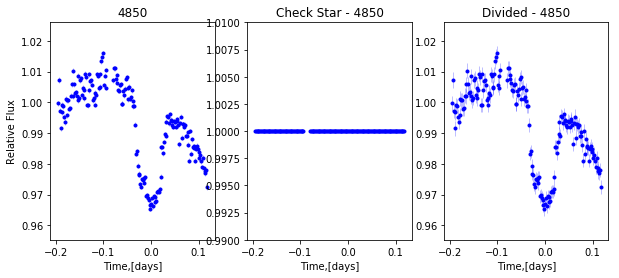

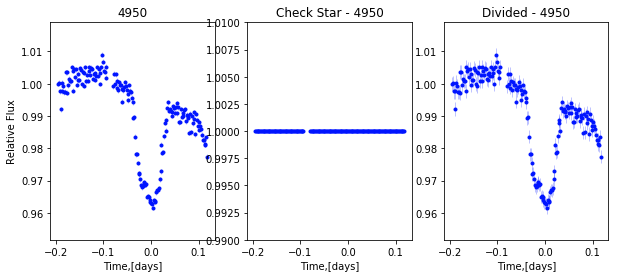

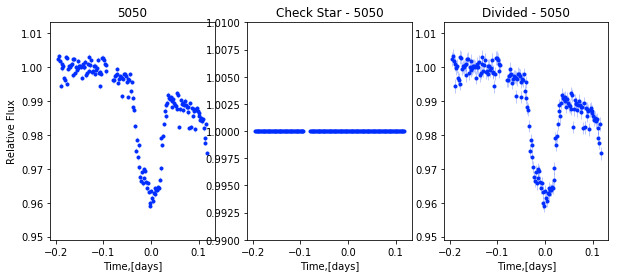

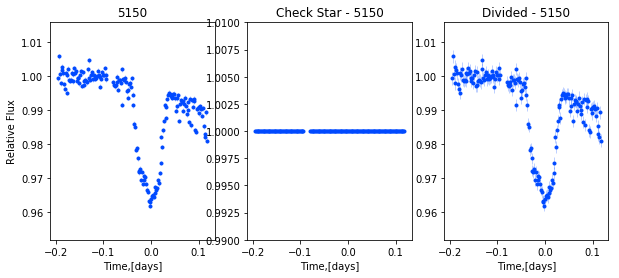

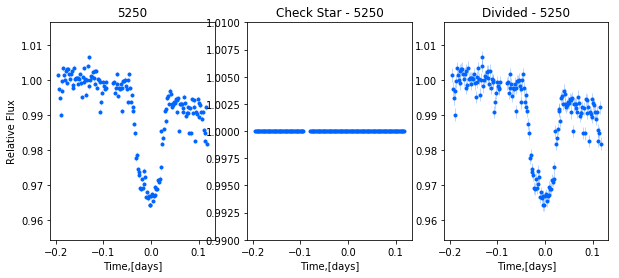

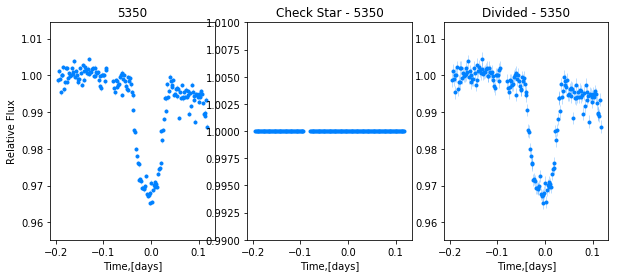

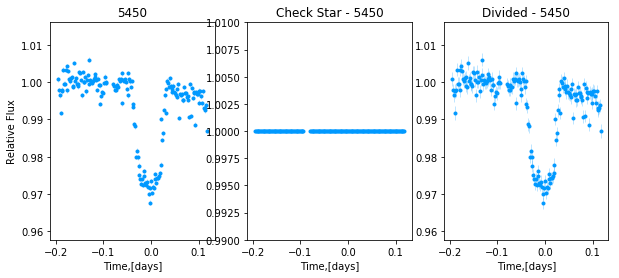

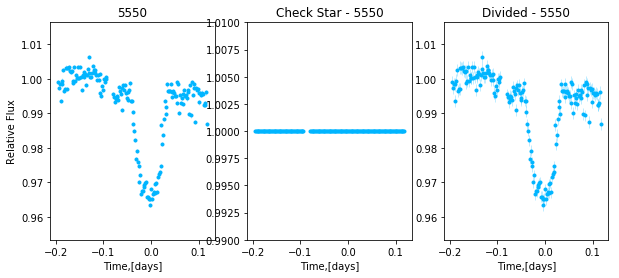

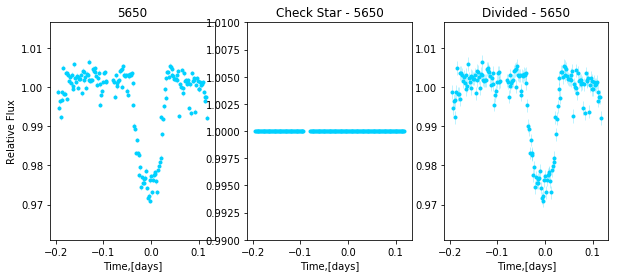

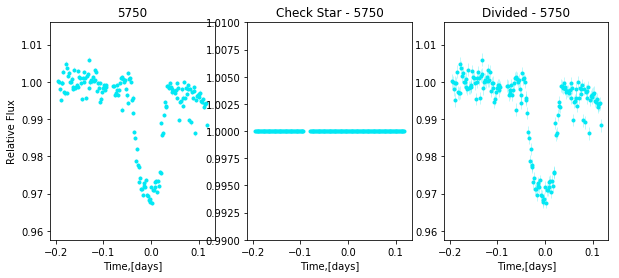

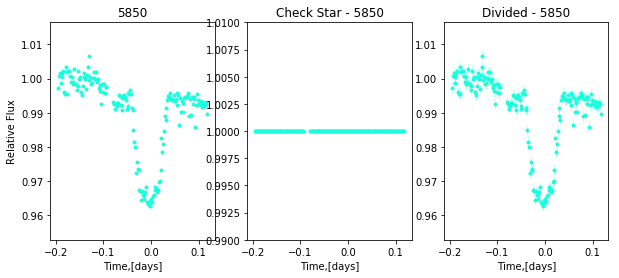

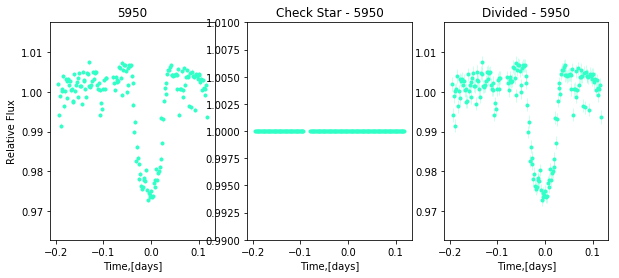

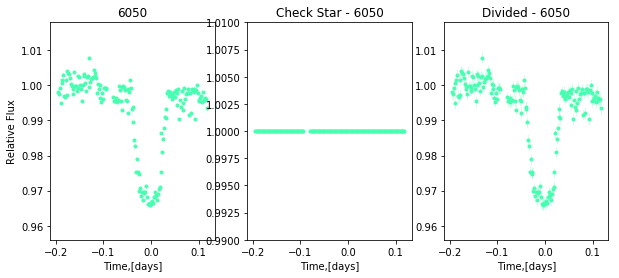

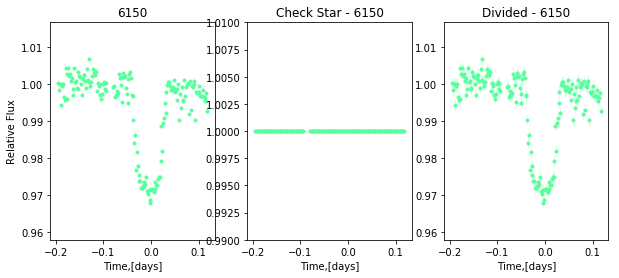

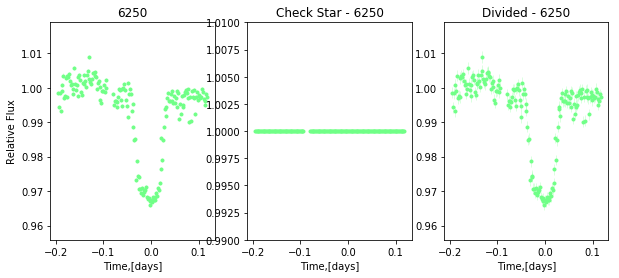

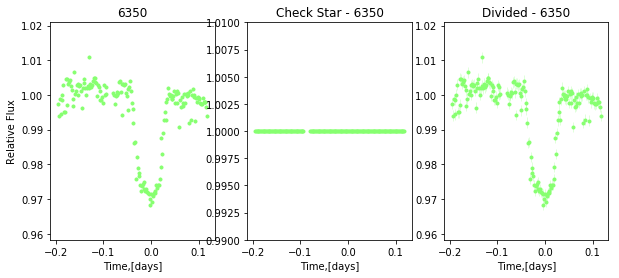

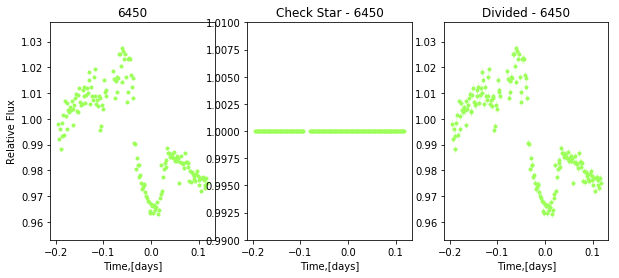

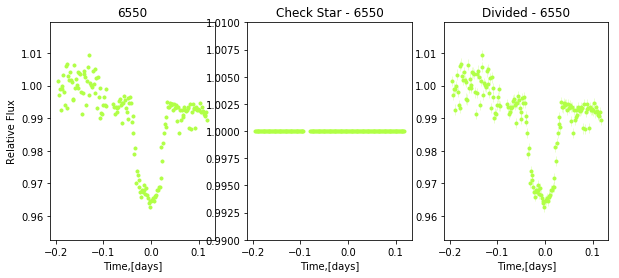

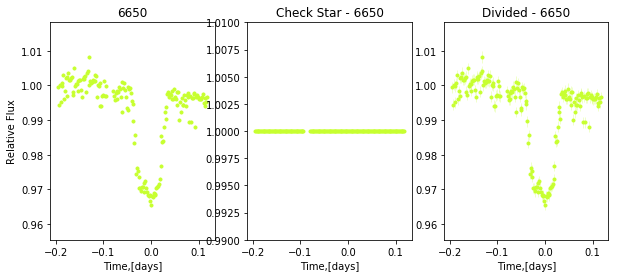

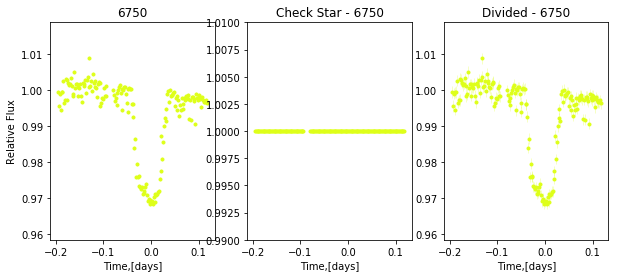

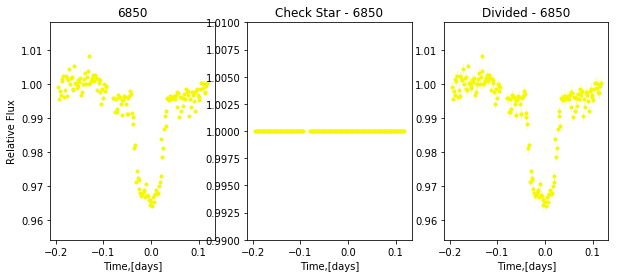

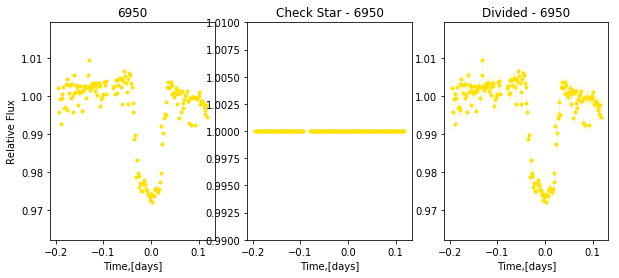

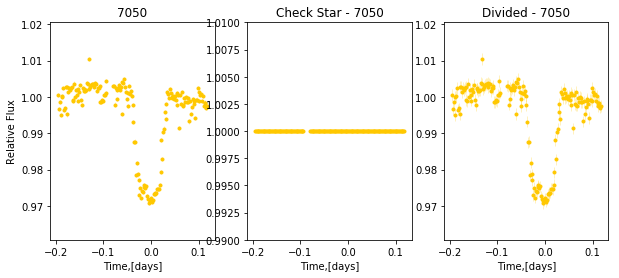

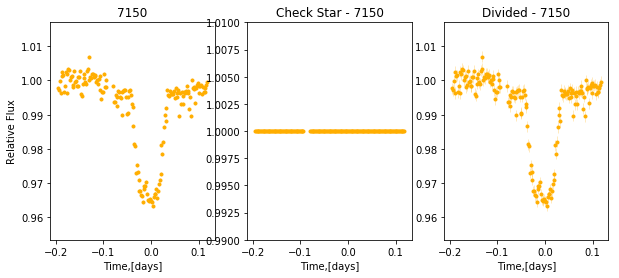

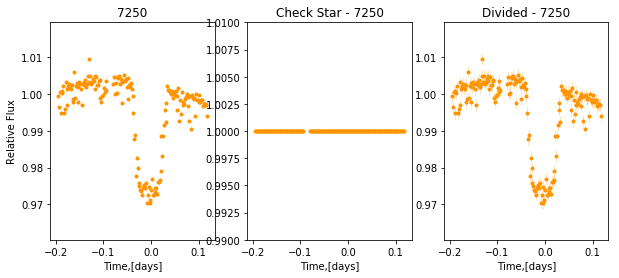

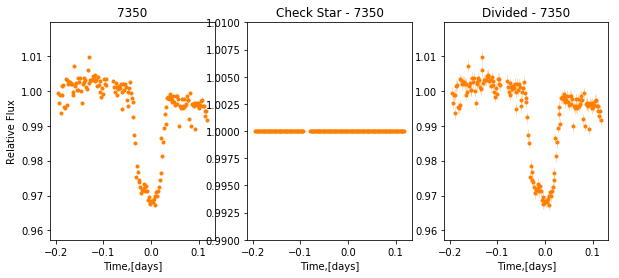

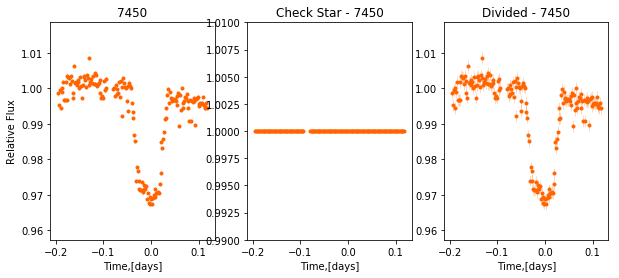

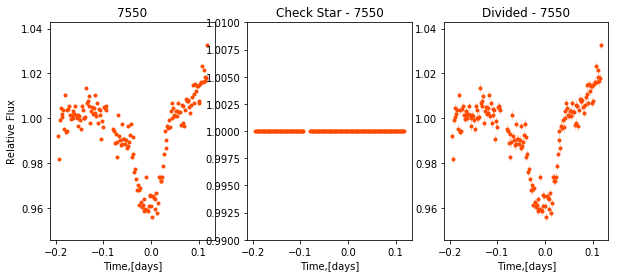

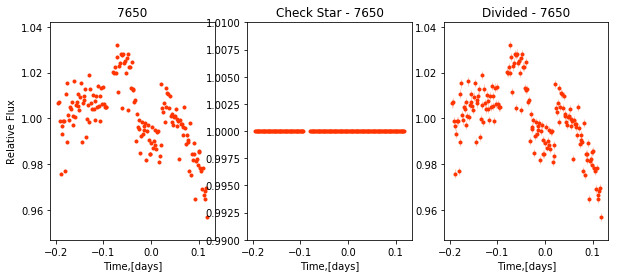

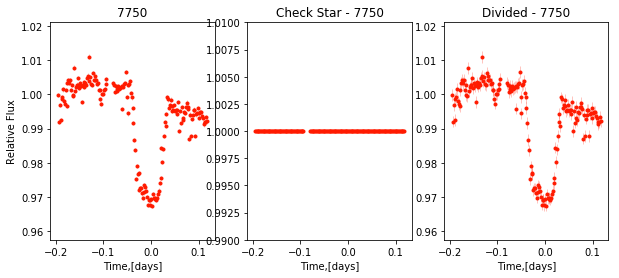

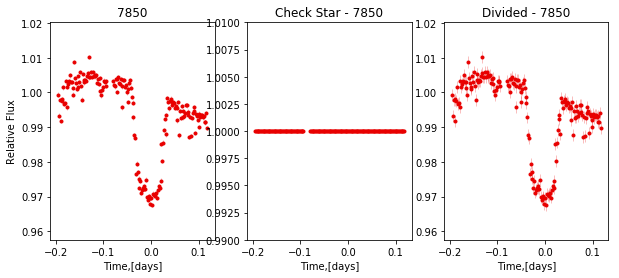

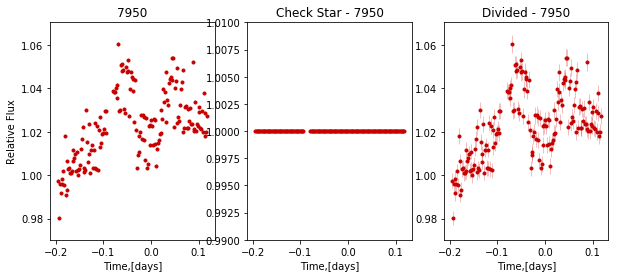

In [24]:
from GenerateLC import LCgen_binns,LCgen_white
#200,100,50,40,30,20,15

corr=False
width=100

#Wasp52
# 1 2 3 4 5 6 7 8 
# X O ~ X ~ X O ~
Cals_ind=[2]  
csn=2

#Wasp4
#1,4,5,7,8,10,11,12
#USE: 5,
#Cals_ind=[4,5,7,8,10,11,12]
#Cals_ind=[5,12]
#csn=5

#HatP26b
#1,2,3,4,5,6,7
# X 1
#Cals_ind=[2]
#csn=2

white=LCgen_white(SAVEPATH,corr,Cals_ind,csn)
binns=LCgen_binns(SAVEPATH,width,corr,Cals_ind,csn)

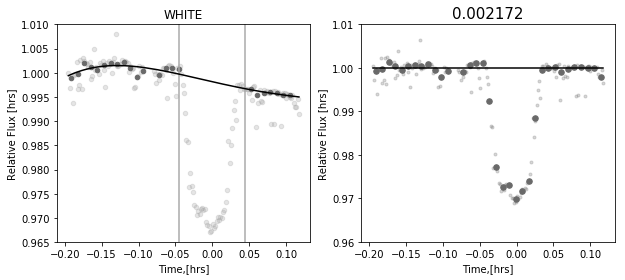

[ 4400.  4600.  4800.  5000.  5200.  5400.  5600.  5800.  6000.  6200.
  6400.  6600.  6800.  7000.  7200.  7400.  7600.  7800.  8000.  8200.
  8400.]
--------- 4500.0 ---------


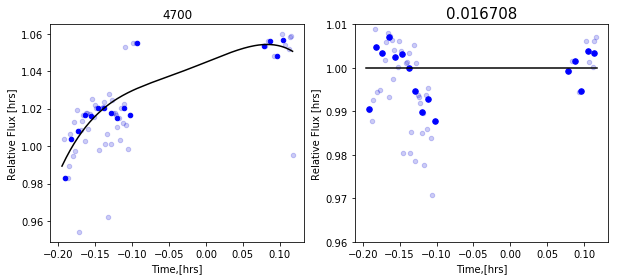

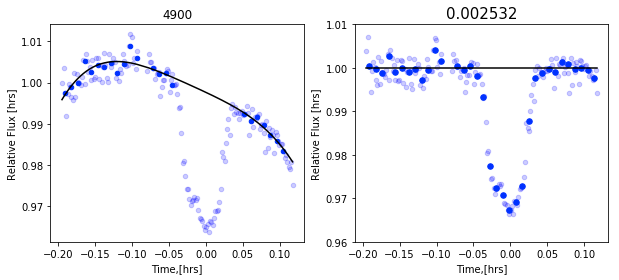

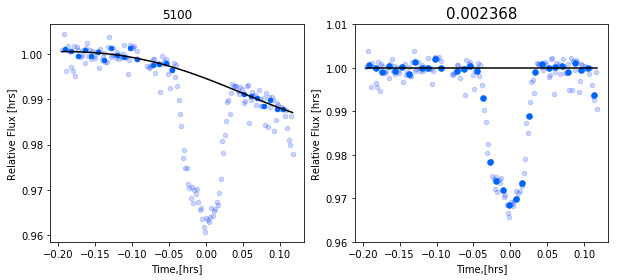

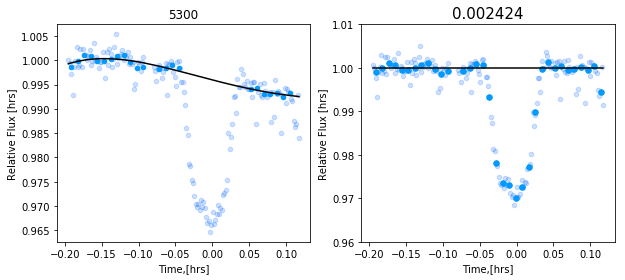

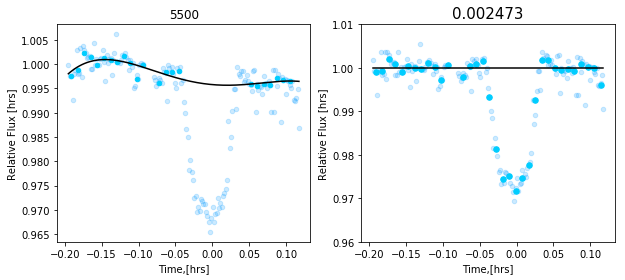

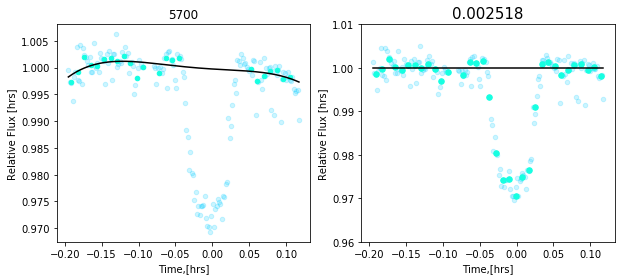

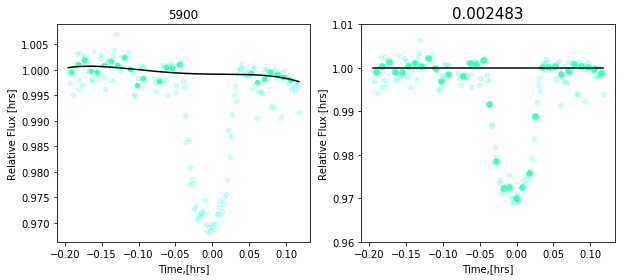

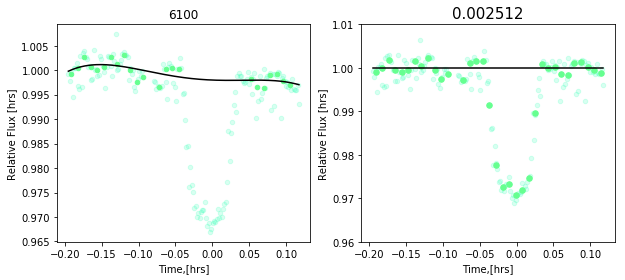

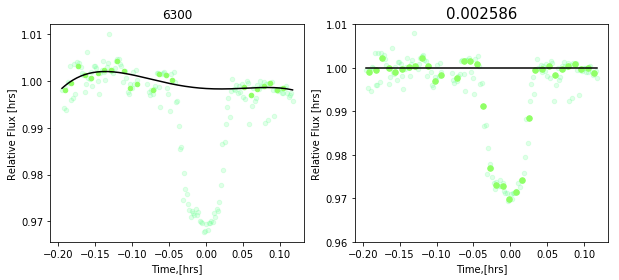

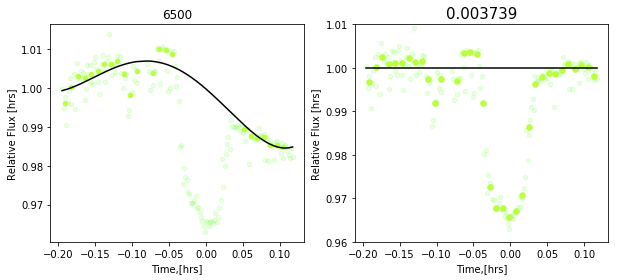

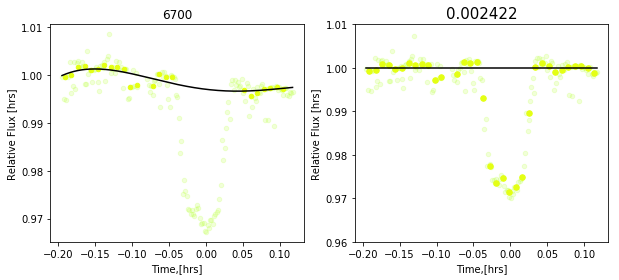

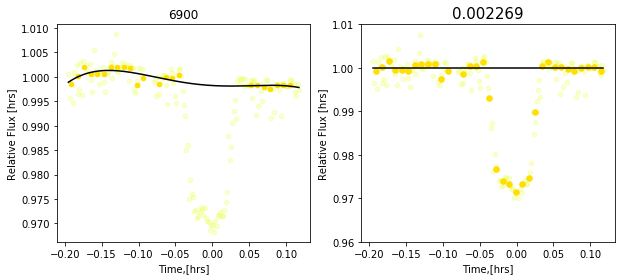

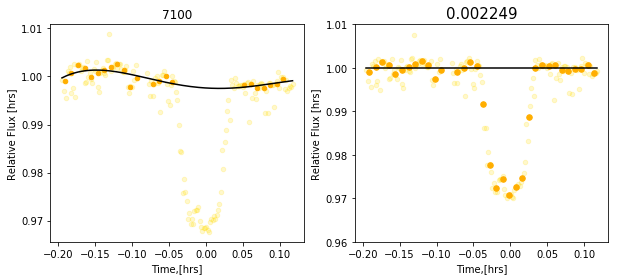

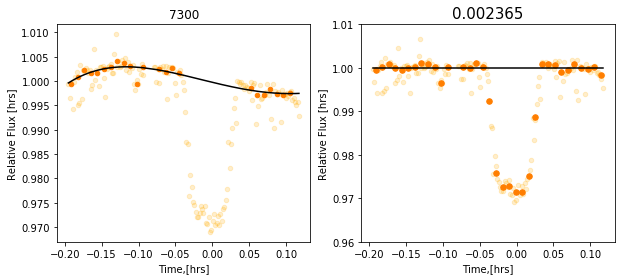

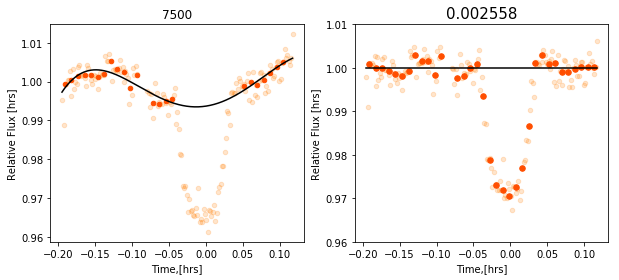

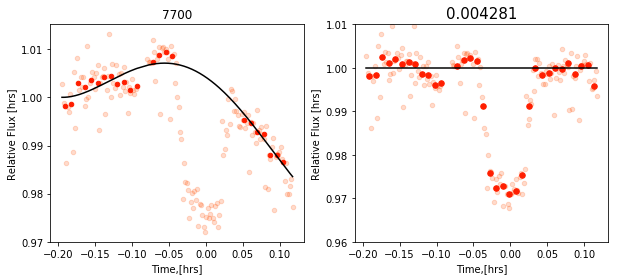

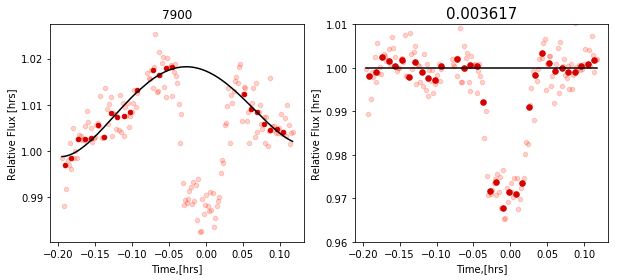

In [8]:
#Hats8 transit 1--- -0.05, 0.06
#W52 transit 1 --- -0.045, 0.035
#W52 transit 2 -- 
from BaselineFitting import blfit_binns,blfit_white

order=4         # polynomial order (in time)
avg=5          # number of points to average together
olow=0.90       # outlier - low end
ohigh=1.06      # outlier - high end
ybot=0.96       # ylim - low end (plot)
ytop=1.01       # ylim - high end (plot)

timein=-0.045
timeeg=0.045

#W52: -0.045, 0.035 
#W4: -0.05,0.045
#Hats8 -0.06,0.06

#corr=False
#width=200


white=blfit_white(SAVEPATH,order,avg,olow,ohigh,ybot,ytop,timein,timeeg,corr)
binns=blfit_binns(SAVEPATH,width,order,avg,olow,ohigh,ybot,ytop,timein,timeeg,corr)

In [22]:
width=100
corr=False
avg=False

nwalkersw=500
burninw=500
nstepsw=1000

nwalkerss=1000
burnins=1000
nstepss=10000

nwalkersl=500
burninl=500
nstepsl=5000

In [23]:
#####################################################                                                                                           
#####################################################                                                                                           
##        Fitting of lightcurves using BATMAN      ##                                                                                           
##  ---------------------------------------------  ##                                                                                           
##  reads in .npz files from Lightcurve_Script.py  ##                                                                                           
##     See README.txt in Magellan/pipeline         ##                                                                                           
#####################################################                                                                                           
#####################################################   

import spotrod

import numpy as np
np.seterr(all='ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import batman

import emcee
import corner

#import astropy
#from astropy.time import Time
#import pyfits                                                                                                                                  

import scipy
from scipy.interpolate import interp1d
from scipy.signal import medfilt

from datetime import datetime
startTime1=datetime.now()

import sys
print (sys.argv)
 

sys.path.insert(0,SAVEPATH) 
from SystemCons import *

from outlier_removal import outlierr

print per, rp, sma

#per=per*24.  #needs to be in hours
#per_e=per_e*24.

pericenter=0.0
k = ecc*np.cos(pericenter)
h = ecc*np.sin(pericenter)
impactparam = sma*np.cos(85.35*np.pi/180.)

#width=200


#################################
#t=np.load(SAVEPATH+'Obs_times.npz')['times']
#n_exp=len(t)
fulltime=np.load(SAVEPATH+'Obs_times.npz')['times']
t_z=np.load(SAVEPATH+'LCwhite_br.npz')['avt']

if corr==True:
    if avg==True:
        t=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avt']
        n_exp=len(t)
            
        lc_data_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avf']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['avf']
        yerr_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['rmse']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['rmse']
            
    else:
        t=np.load(SAVEPATH+'Obs_times.npz')['times']
        n_exp=len(t)
            
        lc_data_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['data']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['data']
        yerr_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['rmse']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['rmse']
else:
    if avg==True:
        t=np.load(SAVEPATH+'LCwhite_br.npz')['avt']
        n_exp=len(t)
            
        lc_data_white=np.load(SAVEPATH+'LCwhite_br.npz')['avf']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['avf']
        yerr_white=np.load(SAVEPATH+'LCwhite_br.npz')['rmse']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['rmse']
            
    else:   
        t=np.load(SAVEPATH+'Obs_times.npz')['times']
        n_exp=len(t)
    
        lc_data_white=np.load(SAVEPATH+'LCwhite_br.npz')['data']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['data']
        yerr_white=np.load(SAVEPATH+'LCwhite_br.npz')['rmse']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['rmse']


#lc_data_white=np.load('/Users/ermay/Desktop/Calibrated_LC_data_white.npz')['calibrated_data'][:,0]
bin_ctr=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['bin_ctr']

####################################################                                                                                            
norm=matplotlib.colors.Normalize(vmin=np.min(bin_ctr),vmax=np.max(bin_ctr))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

####################################################                                                                                            
#              LIMB DARKENING FUNCION              #                                                                                            
####################################################                                                                                            
# U B V R I J H K                                                                                                                               

#limb_dark='quadratic'

wave=[3640,4450,5510,6580,8060,12200]#,16300,21900]                                                                                             

q0_func=interp1d(wave,q0)
q1_func=interp1d(wave,q1)

def quadraticlimbdarkening(r, u1, u2):
    answer = np.zeros_like(r)
    mask = (r<=1.0)
    oneminusmu = 1.0 - np.sqrt(1.0 - np.power(r[mask],2))
    answer[mask] = 1.0 - u1 * oneminusmu - u2 * np.power(oneminusmu,2)
    return answer

# Initialize spotrod.
# Number of intergration rings.
n = 1000

# Midpoint rule for integration.
# Integration annulii radii.
r = np.linspace(1.0/(2*n), 1.0-1.0/(2*n), n)
# Weights: 2.0 times limb darkening times width of integration annulii.
#f = 2.0 * quadraticlimbdarkening(r, u1, u2) / n

spotx=0.0
spoty=0.0
spotradius=0.0
spotcontrast=1.0

####################################################                                                                                            
#              LIGHT CURVE FUNCTION                #                                                                                            
####################################################      
def FULL_LC(t,t0,per,rp,inc,c1,c2,spotx,spoty,spotradius,spotcontrast):
    f=2.0*quadraticlimbdarkening(r,c1,c2)
    t_f=t-t0
    smacm=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    sma=smacm/Rs
    MA=(2*np.pi/per)*t_f
    eta=sma*np.cos(MA)
    xi=sma*np.sin(MA)
    b=sma*np.cos(inc*np.pi/180.)
    planetx=b*eta/sma
    planety=-xi
    z=np.sqrt(planetx**2.+planety**2.)
    planetangle=np.array([spotrod.circleangle(r,rp,z[i]) for i in xrange(z.shape[0])])
    fitlightcurve=spotrod.integratetransit(planetx,planety,z,rp,r,f,np.array([spotx]),np.array([spoty]),np.array([spotradius]),np.array([spotcontrast]),planetangle)
    return fitlightcurve


def lc_func_white(t0,per,rp,inc,c1,c2):
    f=2.0*quadraticlimbdarkening(r,c1,c2)
    t_f=t-t0
    smacm=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    sma=smacm/Rs
    MA=(2*np.pi/per)*t_f
    eta=sma*np.cos(MA)
    xi=sma*np.sin(MA)
    b=sma*np.cos(inc*np.pi/180.)
    planetx=b*eta/sma
    planety=-xi
    z=np.sqrt(planetx**2.+planety**2.)
    planetangle=np.array([spotrod.circleangle(r,rp,z[i]) for i in xrange(z.shape[0])])
    fitlightcurve=spotrod.integratetransit(planetx,planety,z,rp,r,f,np.array([spotx]),np.array([spoty]),np.array([spotradius]),np.array([spotcontrast]),planetangle)
    return fitlightcurve

def lc_func_binns(rp,c1,c2,spotcontrast):
    f=2.0*quadraticlimbdarkening(r,c1,c2)
    planetangle=np.array([spotrod.circleangle(r,rp,z[i]) for i in xrange(z.shape[0])])
    fitlightcurve=spotrod.integratetransit(planetx,planety,z,rp,r,f,np.array([spotx]),np.array([spoty]),np.array([spotradius]),np.array([spotcontrast]),planetangle)
    return fitlightcurve

def lc_func_spots(spotx,spoty,spotradius,spotcontrast):
    fitlightcurve=spotrod.integratetransit(planetx,planety,z,rp,r,f,np.array([spotx]),np.array([spoty]),np.array([spotradius]),np.array([spotcontrast]),planetangle)
    return fitlightcurve

####################################################                                                                                            
#     Prior, Likelihood, Posterior Functions       #                                                                                            
####################################################                                                                                            
def loggaus(mean,sig,param):
    return -np.log(np.sqrt(2*np.pi*sig**2.))-((param-mean)**2.)/(2*sig**2.)

def lnprior(theta,color):
    if color==0:
        t0_f,per_f,rp_f,inc_f,c1_f,c2_f=theta
        if t0_f>t0dn and t0_f<t0up and rp_f>rpdn and rp_f<rpup and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return loggaus(per,per_e,per_f)+loggaus(inc,inc_e,inc_f)
        else:
            return -np.inf
    if color==1:
        rp_f,c1_f,c2_f,spotcontrast=theta
        if spotcontrast<1.0 and spotcontrast>0.0 and rp_f>rpdn and rp_f<rpup and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return 0.0
        else:
            return -np.inf

    if color==2:
        spotx,spoty,spotradius,spotcontrast=theta
        if spotx<=1.0 and spotx>-1.0 and spoty<=1.0 and spoty>-1.0 and spotx**2.+spoty**2.<1.0 and spotcontrast<1.0 and spotcontrast>0.0 and spotradius<=1.0 and spotradius>=0.0:
            return 0.0
        else:
            return -np.inf

def lnlike(theta,flux,err,color):
    if color==0:
        t0,per,rp,inc,c1_f,c2_f=theta
        Ms_s=np.random.normal(loc=Ms,scale=Ms_e)
        Rs_s=np.random.normal(loc=Rs,scale=Rs_e)
        smacm=(((per*24.*60.*60.)**2.*Grav*Ms_s)/(4*np.pi**2.))**(1./3.)
        a=smacm/Rs_s
        fit=lc_func_white(t0,per,rp,inc,c1_f,c2_f)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))
    if color==1:
        rp,c1_f,c2_f,spotcontrast=theta
        fit=lc_func_binns(rp,c1_f,c2_f,spotcontrast)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))
    if color==2:
        spotx,spoty,spotradius,spotcontrast=theta
        fit=lc_func_spots(spotx,spoty,spotradius,spotcontrast)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))
        


def lnprob(theta,flux,err,color):
    prior=lnprior(theta,color)
    if not np.isfinite(prior):
        return -np.inf
    post=prior+lnlike(theta,flux,err,color)
    return post

####################################################                                                                                            
#     RUN MCMC CODE      #                                                                                            
####################################################   

def runmcmc(nwalkers,burnin,nsteps,pos0,data,error,color):
    sampler=emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2.0, args=(data,error,color))
    
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Running Burn-in...'))
                                                                                                                        
    time1=datetime.now()
    p0,test1,test2=sampler.run_mcmc(pos0,burnin)
    time2=datetime.now()
    Output.write('{0} {1} \n'.format('           Time to Run: ', time2-time1))
    sampler.reset()
                                                                                                                          

    Output.write('{0} \n'.format('     -->> Running Chain...'))
    Output.close()
    for i, result in enumerate(sampler.sample(p0,iterations=nsteps)):
        if (i+1)%(nsteps/10) ==0:
            Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
            Output.write('{0} {1} {2} \n'.format(("            {0:5.1%}".format(float(i+1) / nsteps)),'          ', datetime.now()))
            Output.close()

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} {1} \n'.format('     -->> Mean Acceptance Fraction: ', np.mean(sampler.acceptance_fraction)))
    Output.close()
    
    samples=sampler.chain[:,:,:].reshape((-1,pos0.shape[1]))
    
    return samples

    

#####################
#nwalkers=500
#burnin=500
#nsteps=3000

Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','w')

color=0
if color==0:
    nwalkers=nwalkersw
    burnin=burninw
    nsteps=nstepsw
    
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format('>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<'))
    print('>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<')
    
    lc_data_white=outlierr(lc_data_white,5,3)
    lc_data_white=outlierr(lc_data_white,5,3)
    
    #if np.nanmax(yerr_white)==0.0:
    #    yerr_white=np.ones_like(yerr_white)*10**-3.
    
    c1=q0_func(6000)
    c2=q1_func(6000)
    u=[c1,c2]
                                                                                                                          
    #params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
    initial=np.array([t0,per,rp,inc,c1,c2])
    ndim=len(initial)
    
    Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
    Output.close()

    t0_arr=np.linspace(t0dn,t0up,10**6.)
    per_arr=np.linspace(per-5*per_e,per+5*per_e,10**6.)
    rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
    inc_arr=np.linspace(inc-5*inc_e,inc+5*inc_e,10**6.)
    c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
    c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  

    pos0=np.empty([nwalkers,ndim])
    for i in range(nwalkers):
        pos0[i,:]=np.array([np.random.choice(t0_arr),np.random.choice(per_arr),np.random.choice(rp_arr),np.random.choice(inc_arr),np.random.choice(c1_arr),np.random.choice(c2_arr)])
        
    runwhite=runmcmc(nwalkers,burnin,nsteps,pos0,lc_data_white,yerr_white,color)
    
    t0o,pero,rpo,inco,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runwhite, [16, 50, 84], axis=0)))
    t0,per,rp,inc,c1,c2=t0o[0],pero[0],rpo[0],inco[0],c1o[0],c2o[0]
    u=[c1,c2]
    sma=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    sma=sma/Rs

    #params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    #paramsp,mp=lc_func(fulltime,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        
    fitlightcurve=lc_func_white(t0,per,rp,inc,c1,c2)#m.light_curve(params)
    fitlightcurvep=FULL_LC(fulltime,t0,per,rp,inc,c1,c2,spotx,spoty,spotradius,spotcontrast)#fitlightcurve#mp.light_curve(paramsp)
    fitlightcurvez=FULL_LC(t_z,t0,per,rp,inc,c1,c2,spotx,spoty,spotradius,spotcontrast)#fitlightcurve#mp.light_curve(paramsp)

    
    residuals=(fitlightcurve-lc_data_white)*10**6.
    chi2=np.nansum(np.abs(residuals/10**6.)**2.)

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Best Fit Params'))
    Output.write('{0} {1} {2} {3} \n'.format('          t0  : ', t0,  np.round(t0o[1],5),np.round(t0o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          per : ', per, np.round(pero[1],10),np.round(pero[2],10)))
    Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
    Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
    Output.write('{0} {1} {2} {3} \n'.format('          inc : ', inc, np.round(inco[1],5),np.round(inco[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
    Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
    Output.close()

    plt.figure()
#    plt.clf()                                                                                                                                  
    plt.plot(t,lc_data_white,'.',markersize=10,markeredgecolor='black',markerfacecolor='grey')
    plt.plot(t,fitlightcurve,'-',color='black')
    plt.ylim(0.96,1.01)
    plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
#    plt.figtext(0.55,0.60, str(int(bin_wav[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_wav[b]))                                         
    plt.figtext(0.55,0.80, 'White Light', fontsize=25,color='grey')
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/Fit_Orbit_LC_white.png')
    plt.close()

    t0min=np.max([t0dn,t0-5*t0o[2]])
    t0max=np.min([t0up,t0+5*t0o[1]])
    rpmin=np.max([rpdn,rp-5*rpo[2]])
    rpmax=np.min([rpup,rp+5*rpo[1]])
    
    plt.clf()
    corner.corner(runwhite,labels=['t0','per','rp','inc','c1','c2'],truths=[t0,per,rp,inc,c1,c2],range=([t0min,t0max],[per-5*pero[2],per+5*pero[1]],[rpmin,rpmax],[inc-5*inco[2],inc+5*inco[1]],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]]))
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/CornerPlot_white.png')
    plt.close()

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format(' '))
    Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
    Output.write('{0}\n'.format(' '))
    Output.close()

    params=np.array([t0,per,rp,sma,inc,c1,c2])#np.array([params.t0,params.per,params.rp,params.a,params.inc,params.u[0],params.u[1]])
    paramserr=np.array([[t0o[1],t0o[2]],[pero[1],pero[2]],[rpo[1],rpo[2]],[inco[1],inco[2]]])

    np.savez_compressed(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_white.npz',results=runwhite,params=params,paramserr=paramserr,lightcurve_fit=fitlightcurvep,lcfitz=fitlightcurvez,residuals=residuals)
    
    
color=2
    
if color==2:
    
    white_fit=np.load(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_white.npz')['params']
    t0,per,rp,sma,inc,c1,c2=white_fit

    nwalkers=nwalkerss
    burnin=burnins
    nsteps=nstepss
    
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format('>>>>>>>>>> SPOT FITTING <<<<<<<<<<'))
    print('>>>>>>>>>> SPOT FITTING <<<<<<<<<<')
    
    #if np.nanmax(yerr_white)==0.0:
    #    yerr_white=np.ones_like(yerr_white)*10**-3.
    
    #c1=q0_func(6000)
    #c2=q1_func(6000)
    
    spotx=0.0
    spoty=0.0
    spotradius=0.0
    spotcontrast=1.0

    t_f=t-t0
    f=2.0*quadraticlimbdarkening(r,c1,c2)
    #smacm=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    #sma=smacm/Rs
    MA=(2*np.pi/per)*t_f
    eta=sma*np.cos(MA)
    xi=sma*np.sin(MA)
    b=sma*np.cos(inc*np.pi/180.)
    planetx=b*eta/sma
    planety=-xi
    z=np.sqrt(planetx**2.+planety**2.)
    planetangle=np.array([spotrod.circleangle(r,rp,z[i]) for i in xrange(z.shape[0])])
    
    #lc_data_white=medfilt(lc_data_white,kernel_size=5)
    lc_data_white=outlierr(lc_data_white,5,3)
    lc_data_white=outlierr(lc_data_white,5,3)
    
    initial=np.array([spotx,spoty,spotradius,spotcontrast])
    ndim=len(initial)
    
    sx_arr=np.linspace(-1.0,1.0,10**6.)
    sy_arr=np.linspace(-1.0,1.0,10**6.)
    sr_arr=np.linspace(0.0,1.0,10**6.)
    sc_arr=np.linspace(0.0,1.0,10**6.)
    
    pos0=np.empty([nwalkers,ndim])
    for i in range(nwalkers):
        pos0[i,:]=np.array([np.random.choice(sx_arr),np.random.choice(sy_arr),np.random.choice(sr_arr),np.random.choice(sc_arr)])

        
    runspot=runmcmc(nwalkers,burnin,nsteps,pos0,lc_data_white,yerr_white/10.,color)
    
    sxo,syo,sro,sco=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runspot, [16, 50, 84], axis=0)))
    spotx,spoty,spotradius,spotcontrast=sxo[0],syo[0],sro[0],sco[0]
    

    fitlightcurve=lc_func_spots(spotx,spoty,spotradius,spotcontrast)
    fitlightcurvep=FULL_LC(fulltime,t0,per,rp,inc,c1,c2,spotx,spoty,spotradius,spotcontrast)#fitlightcurve#mp.light_curve(paramsp)
    fitlightcurvez=FULL_LC(t_z,t0,per,rp,inc,c1,c2,spotx,spoty,spotradius,spotcontrast)
    
    residuals=(fitlightcurve-lc_data_white)*10**6.
    res_white=residuals
    chi2=np.nansum(np.abs(residuals/10**6.)**2.)
    
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Best Fit Params'))
    Output.write('{0} {1} {2} {3} \n'.format('          sx  : ', spotx,  np.round(sxo[1],5),np.round(sxo[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          sy  : ', spoty, np.round(syo[1],5),np.round(syo[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          sr  : ', spotradius,  np.round(sro[1],5),np.round(sro[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          sc  : ', spotcontrast,  np.round(sco[1],5),np.round(sco[2],5)))
    Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
    Output.close()
    
    plt.figure()
#    plt.clf()                                                                                                                                  
    plt.plot(t,lc_data_white,'.',markersize=10,markeredgecolor='black',markerfacecolor='grey')
    plt.plot(t,fitlightcurve,'-',color='black')
    plt.ylim(0.96,1.01)
    plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
#    plt.figtext(0.55,0.60, str(int(bin_wav[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_wav[b]))                                         
    plt.figtext(0.55,0.80, 'White Light', fontsize=25,color='grey')
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/Fit_Orbit_LC_spot.png')
    plt.close()
    
    sxmax=np.min([1.0,spotx+5*sxo[1]])
    sxmin=np.max([-1.0,spotx-5*sxo[2]])
    symax=np.min([1.0,spoty+5*syo[1]])
    symin=np.max([-1.0,spoty-5*syo[2]])
    srmax=np.min([1.0,spotradius+5*sro[1]])
    srmin=np.max([0.0,spotradius-5*sro[2]])
    scmax=np.min([1.0,spotcontrast+5*sco[1]])
    scmin=np.max([0.0,spotcontrast-5*sco[2]])

    plt.clf()
    corner.corner(runspot,labels=['sx','sy','sr','sc'],truths=[spotx,spoty,spotradius,spotcontrast],range=([sxmin,sxmax],[symin,symax],[srmin,srmax],[scmin,scmax]))
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/CornerPlot_spot.png')
    plt.close()

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format(' '))
    Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
    Output.write('{0}\n'.format(' '))
    Output.close()

    params=np.array([spotx,spoty,spotradius,spotcontrast])
    paramserr=np.array([[sxo[1],sxo[2]],[syo[1],syo[2]],[sro[1],sro[2]],[sco[1],sco[2]]])

    np.savez_compressed(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_spot.npz',results=runspot,params=params,paramserr=paramserr,lightcurve_fit=fitlightcurvep,lcfitz=fitlightcurvez,residuals=residuals)

#########################
color=1

if color==1:
    
    res_white=np.load(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_spot.npz')['residuals']
    white_fit=np.load(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_white.npz')['params']
    t0,per,rp,sma,inc,c1,c2=white_fit
    
    spot_fit=np.load(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_spot.npz')['params']
    spotx,spoty,spotradius,spotcontrast=spot_fit
    #spotx=0.4038
    #spoty=0.207
    #spotradius=0.13986
    #spotcontrast=0.4300
    
    nwalkers=nwalkersl
    burnin=burninl
    nsteps=nstepsl
    
    t_f=t-t0
    #smacm=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    #sma=smacm/Rs
    MA=(2*np.pi/per)*t_f
    eta=sma*np.cos(MA)
    xi=sma*np.sin(MA)
    b=sma*np.cos(inc*np.pi/180.)
    planetx=b*eta/sma
    planety=-xi
    z=np.sqrt(planetx**2.+planety**2.)
    
    for b in range(0,len(bin_ctr)):
        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0} {1} {2}\n'.format('>>>>>>>>>> WAVELENGTH BIN: ' ,bin_ctr[b], ' <<<<<<<<<<'))
        print('>>>>>>>>>> WAVELENGTH BIN: ' ,bin_ctr[b], ' <<<<<<<<<<')
#        Output.write('{0} {1} \n'.format(' -->> WAVLENGTH CENTER = ', bin_ctr[b]))


        lc_data_binns[:,b]=outlierr(lc_data_binns[:,b],5,3)
        lc_data_binns[:,b]=outlierr(lc_data_binns[:,b],5,3)
        #lc_data_binns[:,b]=lc_data_binns[:,b]+res_white*10**-6
    
#        lc_data_binns[:,b]=medfilt(lc_data_binns[:,b],kernel_size=5)

        #if np.nanmax(yerr_binns[:,b])==0.0:
        #    hold=np.ones_like(yerr_binns[:,b])*10**-3.
        #    yerr_binns[:,b]=hold
    
        c1=q0_func(bin_ctr[b])
        c2=q1_func(bin_ctr[b])
        u=[c1,c2]
                                                                                                                          
        #params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
        initial=np.array([rp,c1,c2,spotcontrast])
        ndim=len(initial)
    
        Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
        Output.close()

        rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
        c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
        c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  
        sc_arr=np.linspace(0.1,1.0,10**6.)

        pos0=np.empty([nwalkers,ndim])
        for i in range(nwalkers):
            pos0[i,:]=np.array([np.random.choice(rp_arr),np.random.choice(c1_arr),np.random.choice(c2_arr),np.random.choice(sc_arr)])

        
        runlam=runmcmc(nwalkers,burnin,nsteps,pos0,lc_data_binns[:,b],yerr_binns[b],color)
    
        rpo,c1o,c2o,sco=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runlam, [16, 50, 84], axis=0)))
        #rpo,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84], axis=0)))
        rp,c1,c2,spotcontrast=rpo[0],c1o[0],c2o[0],sco[0]
        u=[c1,c2]

        #params,m=lc_func_binns(rp,c1,c2,spotcontrast)
        #paramsp,mp=lc_func(fulltime,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        
        fitlightcurve=lc_func_binns(rp,c1,c2,spotcontrast)
        fitlightcurvep=FULL_LC(fulltime,t0,per,rp,inc,c1,c2,spotx,spoty,spotradius,spotcontrast)
        fitlightcurvez=FULL_LC(t_z,t0,per,rp,inc,c1,c2,spotx,spoty,spotradius,spotcontrast)
        #fitlightcurvep=fitlightcurve#mp.light_curve(paramsp)
        #fitlightcurvep=mp.light_curve(paramsp)
        
        residuals=(fitlightcurve-lc_data_binns[:,b])*10**6.
        chi2=np.nansum(np.abs(residuals/10**6.)**2.)

        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0} \n'.format('     -->> Best Fit Params'))
        Output.write('{0} {1} \n'.format('          t0  : ', t0))#,  np.round(t0o[1],5),np.round(t0o[2],5)))                                        
        Output.write('{0} {1} \n'.format('          per : ', per))#, np.round(pero[1],5),np.round(pero[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
        Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
        Output.write('{0} {1} \n'.format('          inc : ', inc))#, np.round(inco[1],5),np.round(inco[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
        Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
        Output.write('{0} {1} {2} {3} \n'.format('          sc  : ', spotcontrast,  np.round(sco[1],5),np.round(sco[2],5)))
        Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
        Output.close()

        plt.figure()
#    plt.clf()                                                                                                                                  
        plt.plot(t,lc_data_binns[:,b],'.',markersize=10,markeredgecolor='black',markerfacecolor=scal_m.to_rgba(bin_ctr[b]))
        plt.plot(t,fitlightcurve,'-',color='black')
        plt.ylim(0.96,1.01)
        plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
        plt.figtext(0.55,0.80, str(int(bin_ctr[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_ctr[b]))                                         
#        plt.figtext(0.55,0.60, 'White Light', fontsize=25,color='grey')
        plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/Fit_Orbit_LC_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        rpmin=np.max([rpdn,rp-5*rpo[2]])
        rpmax=np.min([rpup,rp+5*rpo[1]])
        scmin=np.max([0.0,spotcontrast-5*sco[2]])
        scmax=np.min([1.0,spotcontrast+5*sco[1]])
    
        plt.clf()
        corner.corner(runlam,labels=['rp','c1','c2','sc'],truths=[rp,c1,c2,spotcontrast],range=([rpmin,rpmax],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]],[scmin,scmax]))
        plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/CornerPlot_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0}\n'.format(' '))
        Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
        Output.write('{0}\n'.format(' '))
        Output.close()
    
    
        params=np.array([t0,per,rp,sma,inc,c1,c2,spotcontrast])
        #params=np.array([t0,per,rp,sma,inc,c1,c2,spotcontrast])
        #params=np.array([params.t0,params.per,params.rp,params.a,params.inc,params.u[0],params.u[1]])
        paramserr=np.array([[rpo[1],rpo[2]],[c1o[1],c1o[2]],[c2o[1],c2o[2]],[sco[1],sco[2]]])

        np.savez_compressed(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_'+str(int(bin_ctr[b]))+'.npz',results=runlam,params=params,paramserr=paramserr,lightcurve_fit=fitlightcurvep,lcfitz=fitlightcurvez,residuals=residuals)

['/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/ermay/Library/Jupyter/runtime/kernel-67ac3f16-5af9-4631-95d8-df2228c2e515.json']
1.7497798 0.15 7.38338832319


KeyError: 'rmse is not a file in the archive'

In [6]:
print res_white.shape
print fitlightcurve.shape
print lc_data_white.shape

(170, 170)
(170,)
(170, 1)


In [8]:
sxmax=np.min([1.0,spotx+5*sxo[1]])
    sxmin=np.max([-1.0,spotx-5*sxo[2]])
    symax=np.min([1.0,spoty+5*syo[1]])
    symin=np.max([-1.0,spoty-5*syo[2]])
    srmax=np.min([1.0,spotradius+5*sro[1]])
    srmin=np.max([0.0,spotradius-5*sro[2]])
    scmax=np.min([1.0,spotcontrast+5*sco[1]])
    scmin=np.max([0.0,spotcontrast-5*sco[2]])

0.431205700332 0.84106926057


In [11]:
print sxmin,spotx,sxmax
print symin,spoty,symax
print srmin,spotradius,srmax
print scmin,spotcontrast,scmax

 -0.789032501204 -0.785372849791 -0.785363202049
-0.00119861138805 -0.000882526651335 -0.000247542949912
1.0 1.0 1.0
0.0 2.63904659872e-10 2.5301755099e-09


In [13]:
print sxo
print syo
print sro
print sco

(-0.78537284979057376, 1.9295482708292511e-06, 0.00073193028262263926)
(-0.00088252665133520508, 0.00012699674028472522, 6.3216947342538562e-05)
(0.99999999999999989, 0.0, 1.1102230246251565e-16)
(2.6390465987248035e-10, 4.5325417000609614e-10, 1.8313530849033626e-10)


In [14]:
new=np.load(SAVEPATH+'LCwhite_br.npz')['data']

orig=np.load('/Users/ermay/Desktop/Calibrated_LC_data_white.npz')['calibrated_data']

In [15]:
print new.shape
print orig.shape

(170,)
(170, 1)


In [17]:
lc_data_binns=np.load(SAVEPATH+'LC_bins_br_200.npz')['bin_ctr']
print lc_data_binns.shape

(18,)
